# Photonic Crystal Hamiltonian Inference
###       Final Project, Group 5, PHYS201, Harvard University, Spring 2023
####      Group Members: Thi Huong Thao Dinh, Fan Du, Yiting Huang

Test notebook to get PyTensor version of likelihood function working.  Edits by V Manoharan.

In [1]:
#import the package 
import inference

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import pymc as pm

import arviz as az

import pytensor
from pytensor import tensor as pt

## Generating a small test data set based on the generative model
From the previous codeblock, we have a method of generating the eigenvalues of the Hamiltonian based on 5 parameters. These eigenvalues will be the peak position in our multiple Lorentzian Peak Model. For the following codeblock, we will generate a small test data set based on the model parameters. These include coupling parameters $h_{11}, u_{20}, v_{11}$ and atomic energy levels $C,C_2$ (pre-determined in the function, not as parameters, for this initial run) in the Hamiltonian that give us the eigenvalue. In addition, once we derive the eigenvalue (peak positions), we also set the peak height $A_0,A_1,A_2,A_3,A_4$, and the Lorentzian peak width $\sigma_L$.

[0.6262339  0.64022636 0.6633661  0.67737364]


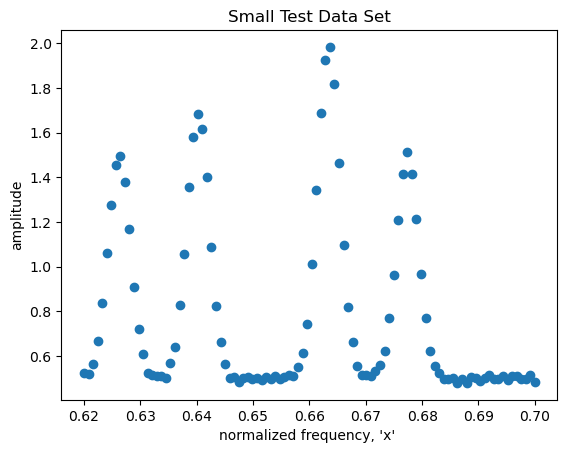

In [2]:
# H functions
#below is a simplified hamiltonian function that we will use for computing pytensor based pymc model 
def ham2(theta, normf):
    """
    simplify the ham2 function, no external function
    ---
    theta: parameters
    normf: spectrum normalized frequency
    ---
    return: predicted spectrum intensity
    """
    
    h11,u20, A0, A1,A2,A3,A4, sigma_L = theta
    C = 0.6346    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 1 (*2 degeneracy)
    C2 = 0.669    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 2 (*2 degeneracy)

    An = [A1,A2,A3,A4]
    ham = [[C2,h11,u20,h11],
          [h11,C,h11,u20],
          [u20,h11,C,h11],
          [h11,u20,h11,C2]]
    Cn = np.real(np.linalg.eigvals(ham))  # peak position
    # make sure eigenvalues are sorted
    Cn = np.sort(Cn)
    print(Cn)

    line_each = [Ai * np.exp(-(normf - Ci)**2 / (2 * sigma_L**2)) for Ai, Ci in zip(An, Cn)]
    line = np.sum(line_each,axis=0)+A0
    return line   # line, theory

# create simulated data
normf = np.linspace(0.62, 0.70, 100)    # normalized frequency, "x" 

# standard deviation of noise
sigma_noise = 0.01
noisey = np.random.normal(0, sigma_noise, 100)

#set all hamiltonian parameters as constant (u20 = v11 in C4 symmetry)
h11 = 0.007
u20 = 1e-5

#set all peak parameters as constant
A0 = 0.5
A1 = 1
A2 = 1.2
A3 = 1.5
A4 = 1
sigma_L = 0.002

theta = [h11,u20,A0,A1,A2,A3,A4,sigma_L] #
y0  = ham2(theta, normf)
y = y0 + noisey
plt.title("Small Test Data Set")
plt.xlabel("normalized frequency, 'x' ")
plt.ylabel("amplitude")
plt.scatter(normf, y);

## Defining the Hamiltonian Matrix

In the following codeblock, we will define a 4 dimension coordinate system to account for the 4 points in k-space unit-cell centered at the $\Gamma$ point: $(1,0,0,0), (0,1,0,0), (0,0,1,0)$ and $(0,0,0,1)$. The $\Gamma$ point itself is $(0,0,0,0)$.

In [3]:
# H functions
#below is a simplified hamiltonian function that we will use for computing pytensor based pymc model 
def likelihood(theta, y, x, sigma_y):
    """
    returns the loglike likelihood of our model
        
    Parameters:
        theta: the parameters in Hamiltonian matrix (list)
        y, x, sigma_y: our data (numpy arrays)
        
    Return:
        the loglike likelihood (float)
    """
    #for our four-basis Hamiltonian, the parameters include
    #interaction-between-modes terms h11, u20;
    #background A0 and heights of 4 peaks A1, A2, A3, A4
    #peak width (assumed to be the same for all peaks) sigma_L
    h11, u20, A0, A1, A2, A3, A4, sigma_L = theta
    
    #energy of each mode is assumed to be fixed
    e = 0.6346    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 1 (*2 degeneracy)
    e2 = 0.669    # for k = (0.05,0) the eigen frequency of uncoupled slab mode 2 (*2 degeneracy)

    #Hamiltonian matrix
    ham_np = np.array([[e2,h11,u20,h11],
                       [h11,e,h11,u20],
                       [u20,h11,e,h11],
                       [h11,u20,h11,e2]])
    ham = pytensor.shared(np.zeros((4,4)))
    for row in range(4):
        for col in range(4):
            ham = pt.set_subtensor(ham[row, col], ham_np[row, col])
    
    #peak heights and peak positions
    An_np = np.array([A1,A2,A3,A4])
    An = pytensor.shared(np.zeros(4))
    for col in range(4):
        An = pt.set_subtensor(An[col], An_np[col])

    Cn = pt.nlinalg.eigh(ham)[0]
    # make sure eigenvalues are sorted
    Cn = pt.sort(Cn)
    
    #expectation value as sum of 4 gaussian peaks and background

    line = A0 + An[0] * pt.exp(-pt.sqr(x - Cn[0]) / (2 * pt.sqr(sigma_L))) + An[1] * pt.exp(-pt.sqr(x - Cn[1]) / (2 * pt.sqr(sigma_L))) + An[2] * pt.exp(-pt.sqr(x - Cn[2]) / (2 * pt.sqr(sigma_L))) + An[3] * pt.exp(-pt.sqr(x - Cn[3]) / (2 * pt.sqr(sigma_L)))
    return pt.sum(-(0.5 / pt.sqr(sigma_y)) * pt.sqr(y - line))

## Infering the parameters based on the simulated data

Now we have acquireda small data set, we want to infer the parameters with PYMC. Because the diagonalization process must be done with actual constants, we must use py_tensor as a tool to diagonalize random variables.

In [4]:
ham_model = pm.Model()
with ham_model:
    # Priors for unknown model parameters    , transform = None  h11, A0, A1, sigma_L = theta
    A0 = pm.Uniform('background',lower=0,upper=1.2)
    A1 = pm.Uniform("A1", lower=0.5, upper=2.5)
    A2 = pm.Uniform("A2", lower=0.5, upper=2.5)
    A3 = pm.Uniform("A3", lower=0.5, upper=2.5)
    A4 = pm.Uniform("A4", lower=0.5, upper=2.5)
    h11 = pm.Uniform('h11',lower=0.003,upper=0.01)
    u20 = pm.Uniform('u20',lower=-1e-3,upper=1e-3)
    # neff = pm.Uniform('neff',2,2.2)         # ignore this for now
    # ratio = pm.Uniform('ratio',0.2,0.4)     # ignore this for now
    sigma_L = pm.Uniform('peak_width',lower=0.0005,upper=0.01)
    
    # likelihood
    theta = pt.as_tensor_variable([h11,u20, A0, A1,A2,A3,A4, sigma_L])
    
    # Likelihood of observations
    pm.Potential("likelihood", likelihood(theta, y, normf, sigma_noise))
    idata = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [background, A1, A2, A3, A4, h11, u20, peak_width]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 44 seconds.


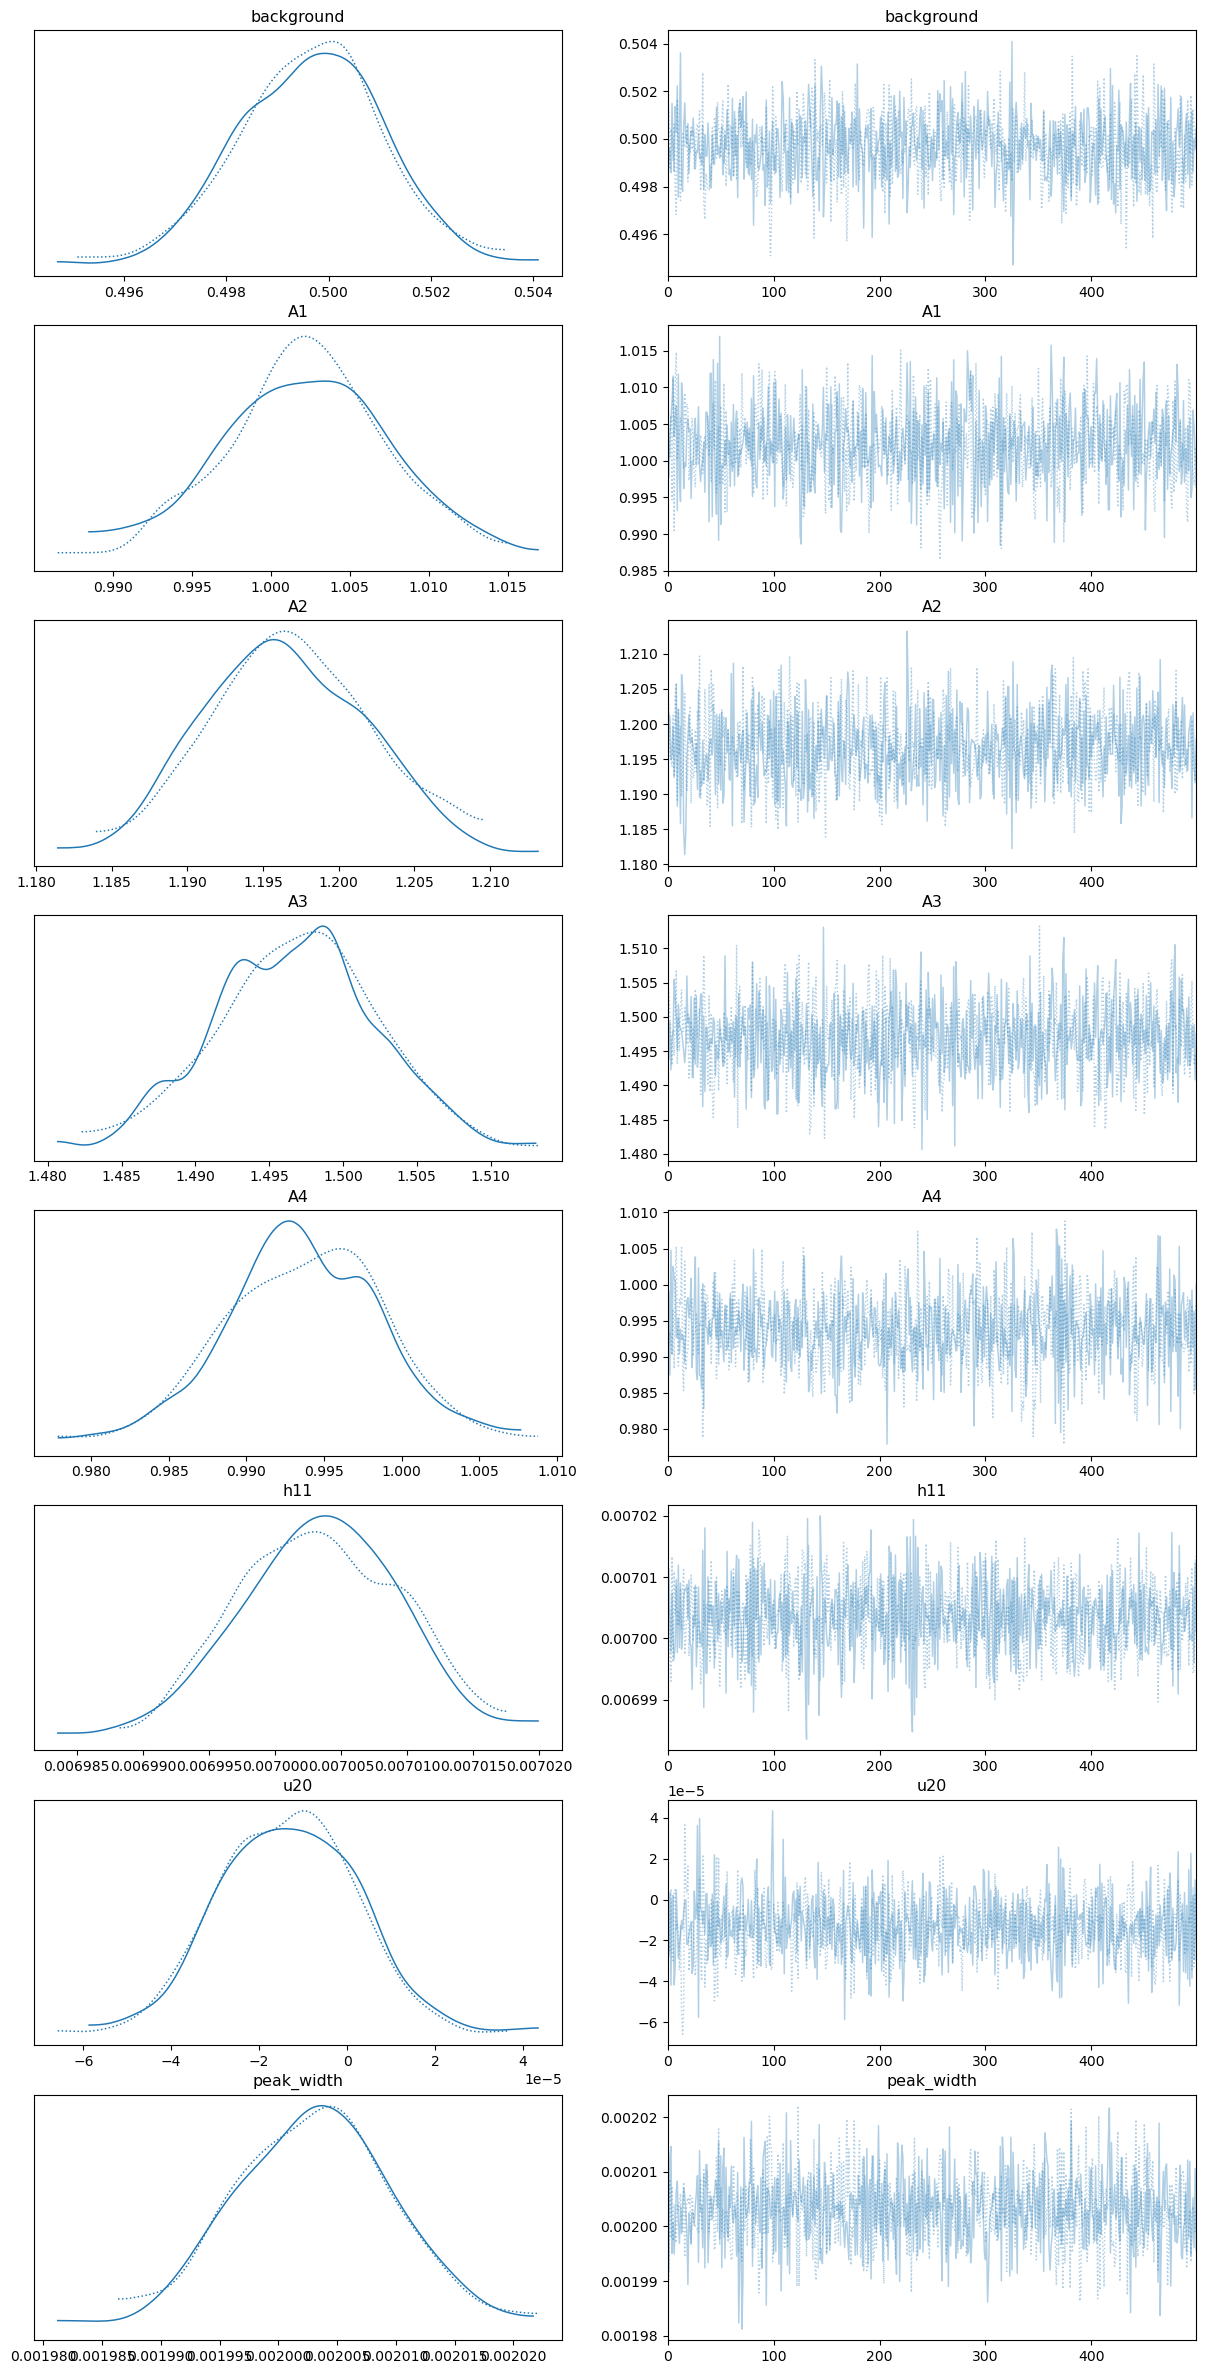

In [5]:
az.plot_trace(idata,figsize=(15,30));

In [6]:
summary = az.summary(idata)
display(summary)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
background,0.500,0.001,0.497,0.502,0.0,0.0,1403.0,923.0,1.00
A1,1.002,0.005,0.993,1.012,0.0,0.0,1641.0,678.0,1.01
A2,1.197,0.005,1.188,1.208,0.0,0.0,1991.0,756.0,1.00
A3,1.497,0.005,1.487,1.507,0.0,0.0,1547.0,876.0,1.00
A4,0.994,0.005,0.984,1.004,0.0,0.0,1611.0,757.0,1.00
h11,0.007,0.000,0.007,0.007,0.0,0.0,1760.0,673.0,1.01
u20,-0.000,0.000,-0.000,0.000,0.0,0.0,1773.0,700.0,1.00
peak_width,0.002,0.000,0.002,0.002,0.0,0.0,1396.0,843.0,1.00


[0.62623013 0.64023013 0.66336987 0.67736987]


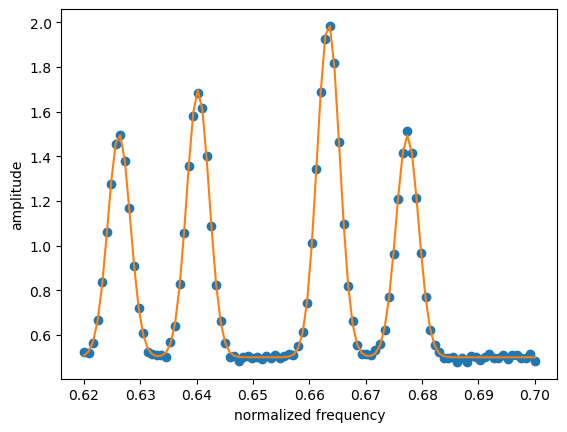

In [7]:
A0, A1, A2, A3, A4, h11, u20, sigma_L = summary['mean'].values
theta = [h11, u20, A0, A1, A2, A3, A4, sigma_L]
model_predictions = ham2(theta, normf)
plt.xlabel("normalized frequency")
plt.ylabel("amplitude")
plt.plot(normf, y, 'o')
plt.plot(normf, model_predictions);